# Tutorial 3: Initializing a large-scale chain

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import tqdm as notebook_tqdm
import skgstat as skg

In [3]:
# load compiled bed elevation measurements
df = pd.read_csv('ByrdGlacierDataGridded.csv')

In [4]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [6]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [7]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(350000.0, 600000.0, -1000500.0, -725500.0)

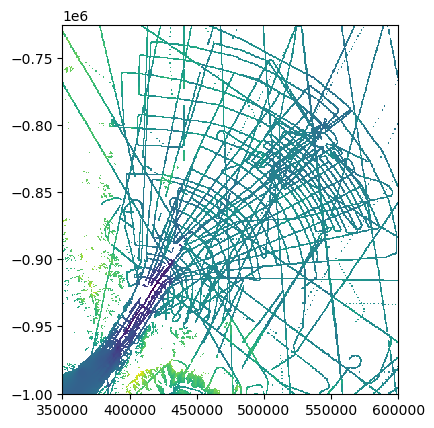

In [8]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [9]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

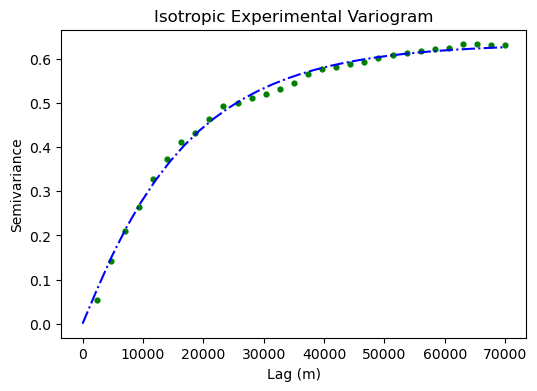

In [10]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 70000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [11]:
V1_p

[45871.21567441265, 0.6342021644009772, 0.5432206806713624, 0]

In [12]:
V1_p = [83251.42284193831, 1.8417237215825735, 0.9952450731725953, 0]

In [ ]:
# 1) Grid the normal-score bed at this tutorial's resolution (500 m)
res = 500  # keep consistent with xx, yy
# Build a tidy table
df_nbed = pd.DataFrame({
    'X': df['x'],
    'Y': df['y'],
    'Nbed': df['Nbed']
})
# Drop NaNs before gridding
df_nbed = df_nbed.dropna(subset=['Nbed'])

# Use gstatsim Gridding helpers
xmin, xmax = np.min(x_uniq), np.max(x_uniq)
ymin, ymax = np.min(y_uniq), np.max(y_uniq)
pred_grid = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

# 2) Variogram params from V1 (Lab 3: Matern)
azimuth = 0
nugget = V1_p[3] if len(V1_p) > 3 else 0
major_range = V1_p[0]
minor_range = V1_p[0]
sill = V1_p[1]
smoothness = V1_p[2]
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

# 3) Choose neighbors/search 
k = 48
rad = 80000  

# 4) Ordinary kriging + SGS in normal-score space
sim = gs.Interpolation.okrige_sgs(
    pred_grid, df_nbed, 'X', 'Y', 'Nbed',
    k, vario_list, rad, quiet=False, seed=0
)

# 5) Back-transform to original elevation space 
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze()

# 6) Upsample the 2-km simulation back onto the  xx,yy grid
import verde as vd  

kn = vd.KNeighbors(k=1)
kn.fit((pred_grid[:, 0], pred_grid[:, 1]), sim_trans)   # coarse coords -> coarse values
sgs_bed = kn.predict((xx.ravel(), yy.ravel())).reshape(xx.shape)

# 7) Enforce physically valid thickness 
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness <= 0) & (bedmap_mask == 1), bedmap_surf - 1, sgs_bed)

# 8) SAVE SGS BED TO TEXT
np.savetxt('sgsOG_bed.txt', sgs_bed)

In [13]:
# load bed generated by Sequential Gaussian Simulation
sgs_bed = np.loadtxt('sgsOG_bed.txt')

### Then initiating the chain

#### Initiate an object of the class chain_crf

Let's first initiate the chain. Here, we created an object of the class chain_crf. This initialization process requires several input that are essential for later calculations

In [14]:
grounded_ice_mask = (bedmap_mask == 1)

In [15]:
largeScaleChain = MCMC.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


Now, the object 'largeScaleChain' have all the properties you have assigned in the initialization process. Try typing *largeScaleChain.xx* or *largeScaleChain.cond_bed*, or any other argument to check them.

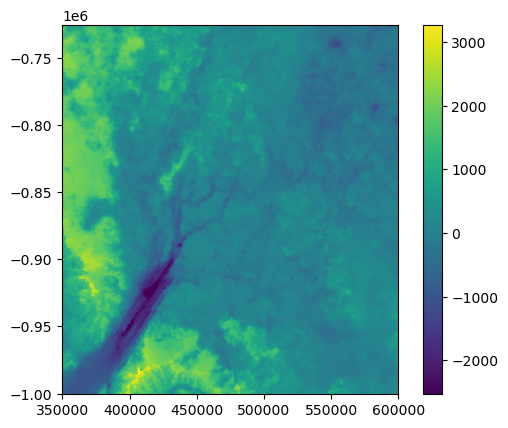

In [16]:
plt.pcolormesh(xx, yy, largeScaleChain.initial_bed)
plt.axis('scaled')
plt.colorbar()

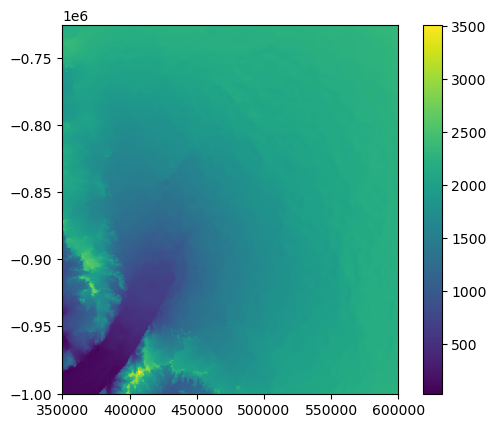

In [17]:
plt.pcolormesh(xx, yy, largeScaleChain.surf)
plt.axis('scaled')
plt.colorbar()

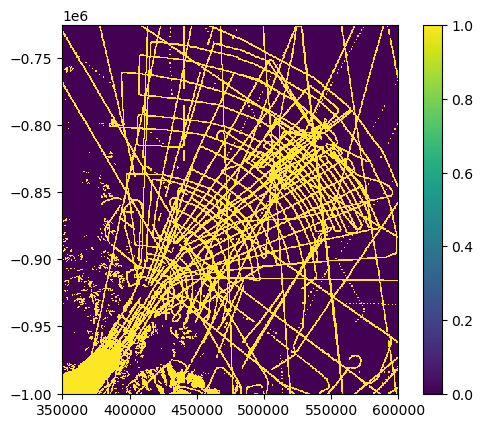

In [18]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask)
plt.axis('scaled')
plt.colorbar()

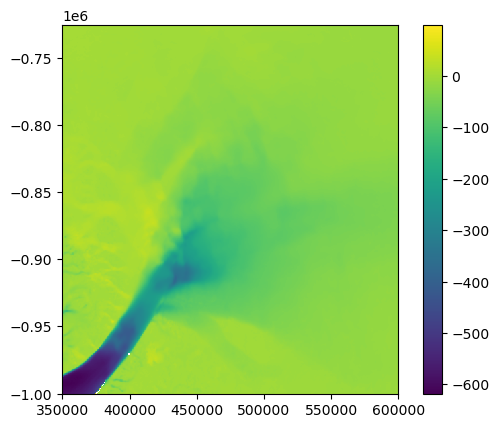

In [19]:
plt.pcolormesh(xx, yy, largeScaleChain.velx)
plt.axis('scaled')
plt.colorbar()

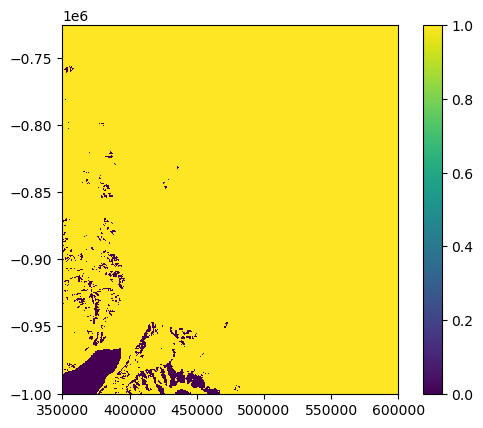

In [20]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask)
plt.axis('scaled')
plt.colorbar()

The second function required, is *set_update_region*. In this function, the first boolean argument decide whether the MCMC update will be inside the high velocity, the second argument specify the exact region of high velocity (where the high_vel_mask == 1)

In [21]:
largeScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


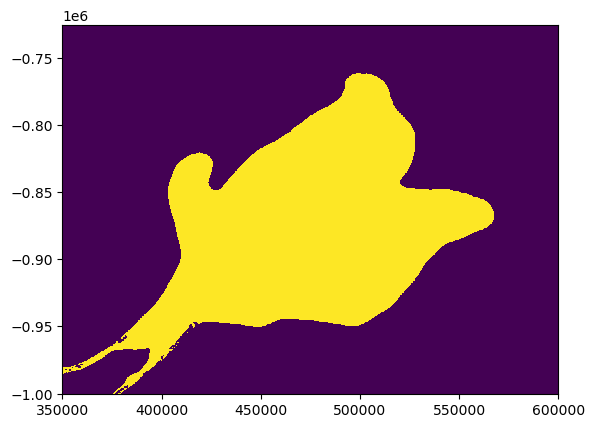

In [22]:
plt.pcolormesh(xx,yy,highvel_mask)

We also want to specify how we want to define the loss function used in the chain.

*map_func* determine the distribution of mass conservation residuals, whereas the *diff_func* determine the distribution of the difference between radar measurements and simulated topography. If the residuals has a Gaussian distribution, the corresponding function will be 'sumsquare'. If you do not want to include either of these loss, simple put *map_func = None* or *diff_func = None*. 

*sigma_mc* and *sigma_data* determine the standard deviation of the distribution of mass conservation residual or differences to radar data. *massConvInRegion* and *dataDiffInRegion* specify whether the two losses should be calculated for only inside the high velocity region or not

In [23]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

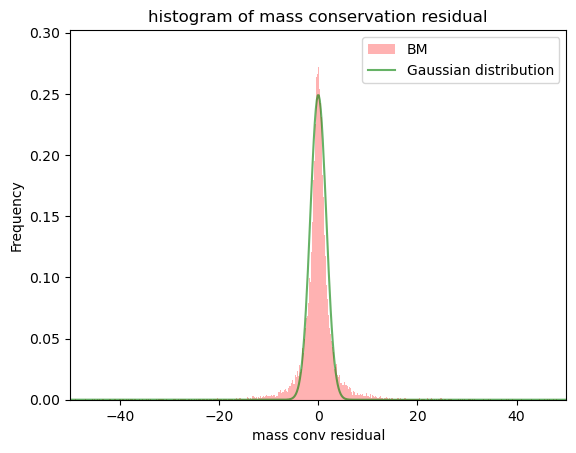

In [24]:
sigma3 = 1.6
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

Setting up the loss function for the large-scale chain. Here, we only use mass conservation residuals as the loss and ignore the different to bed elevation measurements, because the chains will always perserve the radar measurements.

Use 'sumsquare' will set the loss function as sum of squared mass conservation residuals inside the high-velocity region, which represent the pdf of a Gaussian distribution with standard deviation 'sigma_mc'

In [25]:
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)

To directly calculate the loss of BedMachine topography in terms of mass conservation residuals, we can directly calls:

largeScaleChain.loss(mass_conservation_residuals, difference_to_radar_measurements)

the _loss()_ function returns three values: the total loss, mass conservation loss (loss based on mass conservation residuals) and measurements data loss (loss based on differences between the topography and the radar measurements). The total loss equals mass conservation loss plus radar measurements loss.

Because we only set-up the mass conservation loss, the difference_to_radar_measurements can be left out

In [26]:
largeScaleChain.loss(mc_res_bm, 0)

(42017.77725191952, 42017.77725191952, 0.0)

For more information regarding these two functions, please check the documentation for MCMC.py

An example of setting up both mass conservation loss and measurements data loss

largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True,
                             diff_func='sumsquare', sigma_data=10, dataDiffInRegion=True)

Then the loss function will return different things

largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)

will returns, for example

(2206762.607690888, 139380.26325314105, 2067382.3444377468)

Here, the three values represents the total loss, the mass conservation loss, and the radar measurements loss.

#### Initiate an object of the class RandField

Next step is to set up the parameters of the random field perturbation

In [49]:
#range_max and range_min changes topographies features' lateral scale
#by default, I set range_max to variogram range
range_max_x = 90e3   
range_max_y = 90e3
range_min_x = 25e3
range_min_y = 25e3
scale_min = 300      
scale_max = 600
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)

Before using the `RandField` object in an MCMC chain or for field generation, 
 call function `set_block_sizes` to initialize block size ranges; 
 call function `set_weight_param` to set up conditional weighting parameters; 
 call function 'set_generation_method' to set up method used to generate random fields.
ERROR! Session/line number was not unique in database. History logging moved to new session 220


Then we can set up the size of the blocks used in the update

*set_block_sizes* function create a list of possible block sizes, which will be accessible via rf1.pairs after the function is called.

*set_block_sizes* function also has an optional argument *steps*, it specify how many 'steps' between the min_block and max_block will be divided into. For example, for min_block_x = 20 and max_block_x = 50, steps = 4 will divide the range into [20, 30, 40, 50]. For min_block_y = 10 and max_block_y = 55, it will divide the range into [10, 25, 40, 55]. Then each size on the list for x will pair up with all size on the list for y, creating a list of following

rf1.pairs = [[20,10],[20,25],[20,40],[20,55],[30,10],[30,25],[30,40],[30,55],[40,10],[40,25],[40,40],[40,55],[50,10],[50,25],[50,40],[50,55]]

When randomly deciding the size of the block, one of the size on the list will be chosen and will be used

In [50]:
min_block_x = 90     # between 80 and 100
max_block_x = 130    # between 120 and 150
min_block_y = 90
max_block_y = 130
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Finally, if you wish to use conditional block update, then the RandField object requires specifying the logistic function used to calculate the conditioning weight of the random field

The logistic function is used to calculate the weight for conditioning to the edge of the block and the weight for conditioning to radar measurements. When updating the field, the weight will be 1 at conditioning data and block edges, and it logistically decays to 0 at location *max_dist* away from any conditioning data

In [51]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)

Set the generation method using the original gstools random field generator or the spectral synthesis generator.

In [52]:
rf1.set_generation_method(spectral=True)

#### Run the Markov chain

At last, these information need to be known to the crf chain. The function *set_crf_data_weight* calculate the weight for conditioning to the radar measurements

In [53]:
largeScaleChain.set_crf_data_weight(rf1)
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


In [54]:
np.savetxt('data_weightOG4.txt', largeScaleChain.crf_data_weight)

In [55]:
largeScaleChain.crf_data_weight = np.loadtxt('data_weightOG4.txt')
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


And then we can start the chain by specifying how many iterations it should go through

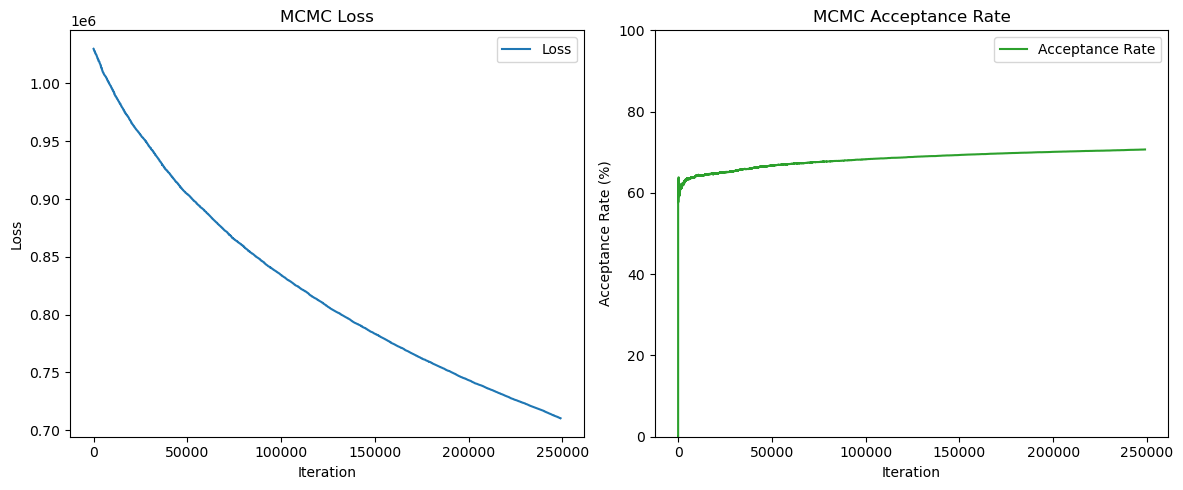

  0%|          | 0/249999 [00:00<?, ?it/s]

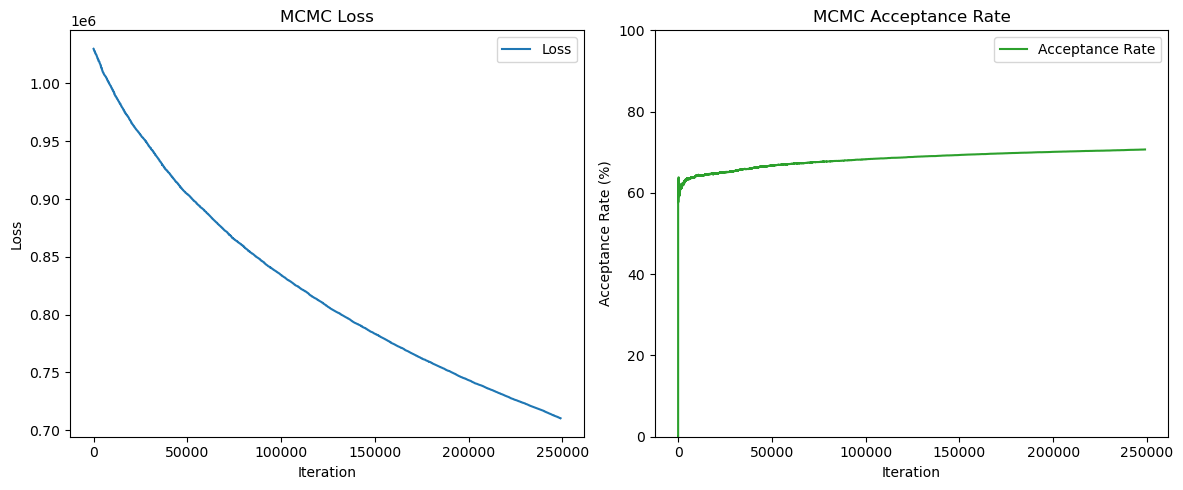

In [33]:
seed = 20251019
rng = np.random.default_rng(seed)

bed_0 = largeScaleChain.initial_bed.copy()

beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=250000, RF=rf1, rng_seed=rng, only_save_last_bed=True, info_per_iter = 1000, progress_bar=True, plot=True)

### Verify Results

We can check several aspects of the results:

- How the topography deviate from radar measurements

- Mass flux residuals of the current topography

- How loss reduce over time

- Variogram of the simulated topography

In [60]:
bed_initial = np.loadtxt('sgsOG_bed.txt')
bed_final = np.loadtxt('bedsOG_at_2572000th_iteration')  

print(f"Initial bed shape: {bed_initial.shape}")
print(f"Final bed shape: {bed_final.shape}")


Initial bed shape: (550, 500)
Final bed shape: (550, 500)


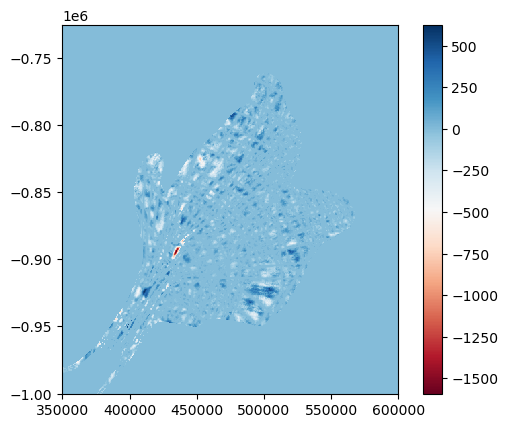

In [61]:
plt.pcolormesh(xx,yy,bed_final-bed_initial,cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

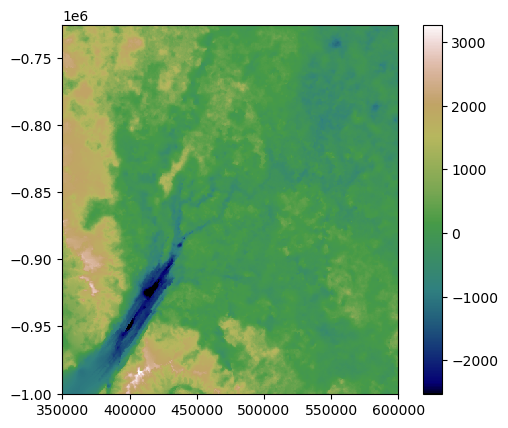

In [62]:
plt.pcolormesh(xx,yy,bed_initial,cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()

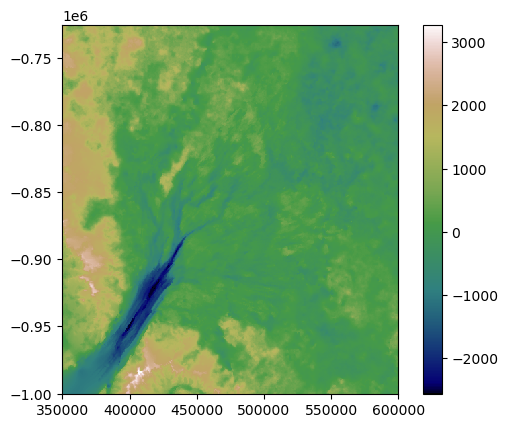

In [63]:
plt.pcolormesh(xx,yy,bed_final,cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()

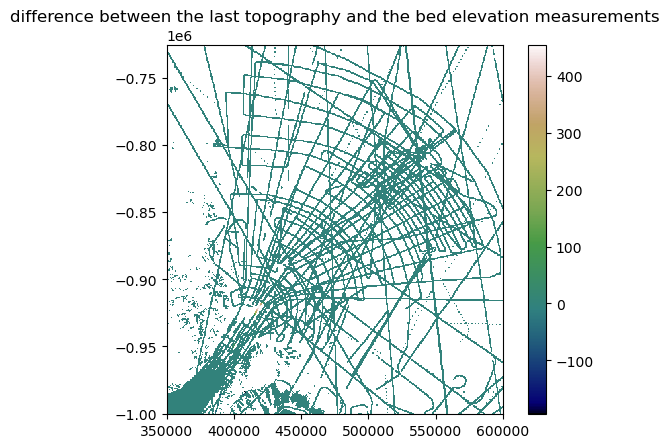

In [64]:
plt.pcolormesh(xx,yy,bed_final - cond_bed,cmap='gist_earth')
plt.title('difference between the last topography and the bed elevation measurements')
plt.axis('scaled')
plt.colorbar()

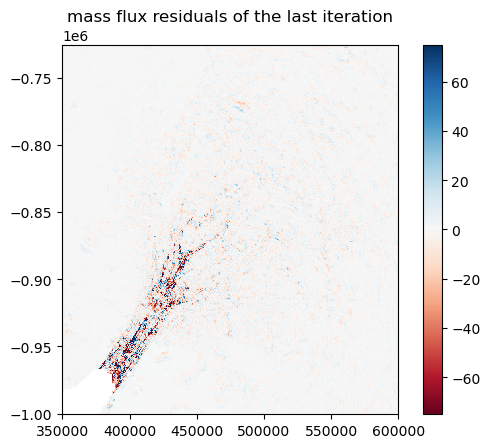

In [65]:
mass_flux_res = Topography.get_mass_conservation_residual(bed_final,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mass_flux_res,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of the last iteration')
plt.axis('scaled')
plt.colorbar()

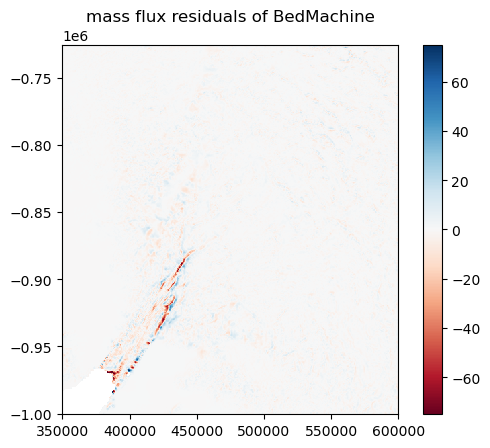

In [66]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mc_res_bm,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of BedMachine')
plt.axis('scaled')
plt.colorbar()

In [67]:
loss_bedmachine = largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)
loss_bedmachine

(42017.77725191952, 42017.77725191952, 0.0)

In [70]:
df['simulated_topography'] = sgs_bed.flatten()

In [71]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["simulated_topography"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
#values = df_sampled['simulated_topography']
values = df_sampled['simulated_topography']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_sim = V1.bins
ydata_sim = V1.experimental
V1_p = V1.parameters

In [72]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['cond_bed']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V2 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_cond = V2.bins
ydata_cond = V2.experimental
V2_p = V2.parameters

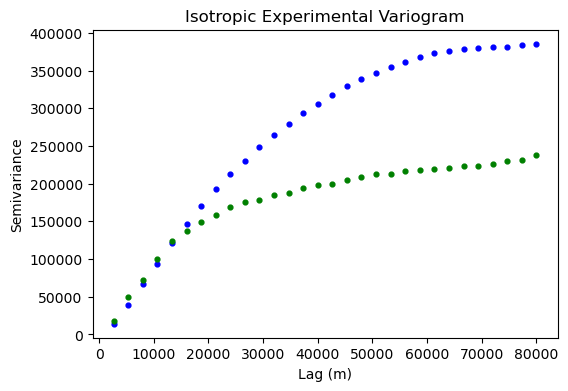

In [73]:
# compare experimental variogram
plt.figure(figsize=(6,4))
plt.scatter(xdata_sim, ydata_sim, s=12, c='b', label='variogram for simulated topography')
plt.scatter(xdata_cond, ydata_cond, s=12, c='g', label='variogram for radar measurements')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

### Save Results

Please remember to save the result for comparison later. For example, I always save the loss of every iteration, the acceptance rate (steps), and some topography.

For example, you can save the topography every 1000 iteration:

In [56]:
beds.shape

(1000, 550, 500)

In [ ]:
seed = 20251019
rng = np.random.default_rng(seed)
largeScaleChain.initial_bed = np.loadtxt('bedsOG_at_2572000th_iteration')

for i in range(2572000, 2573000, 1000):
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = largeScaleChain.run(n_iter=1000, RF=rf1)
    np.savetxt('lossOG_'+str(i)+'to'+str(i+1000), loss)
    np.savetxt('stepsOG_'+str(i)+'to'+str(i+1000), steps) 
    np.savetxt('bedsOG_at_' + str(i+1000) +'th_iteration', beds[-1])
    largeScaleChain.initial_bed = beds[-1]

Or you can save beds at more iterations. For the example, the code below save beds for every 100 iteration, while we are running the chain for 1000 iterations

And these data can be loaded later and concatenated together to showcase the complete chain

In [58]:
all_loss_mc = []
for i in range(0, 2572000, 1000):  # <-- Changed to 1000000
    loss_mc_chunk = np.loadtxt(f'lossOG_{i}to{i+1000}')
    all_loss_mc.append(loss_mc_chunk)

loss_mc = np.concatenate(all_loss_mc)

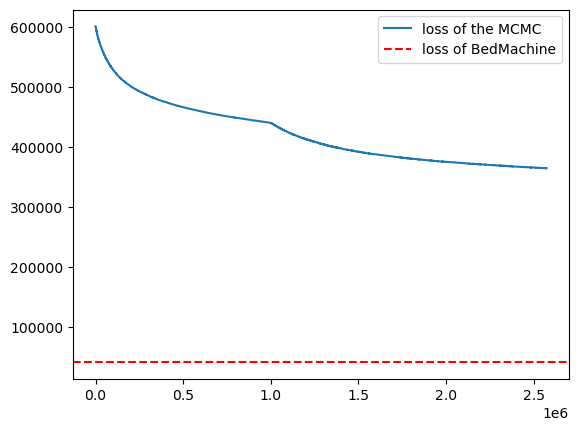

In [59]:
plt.plot(loss_mc,label='loss of the MCMC')
plt.axhline(loss_bedmachine[0],ls='--',c='red',label='loss of BedMachine')
plt.legend()

A chain can be continued by assigning the initial bed

In [ ]:
plt.pcolormesh(xx,yy,bed_250k - beds2[0],cmap='viridis')
plt.axis('scaled')
plt.colorbar()

In [ ]:
plt.pcolormesh(xx,yy,beds2[-1]-beds2[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

In [ ]:
plt.pcolormesh(xx,yy,beds2[-1],cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()

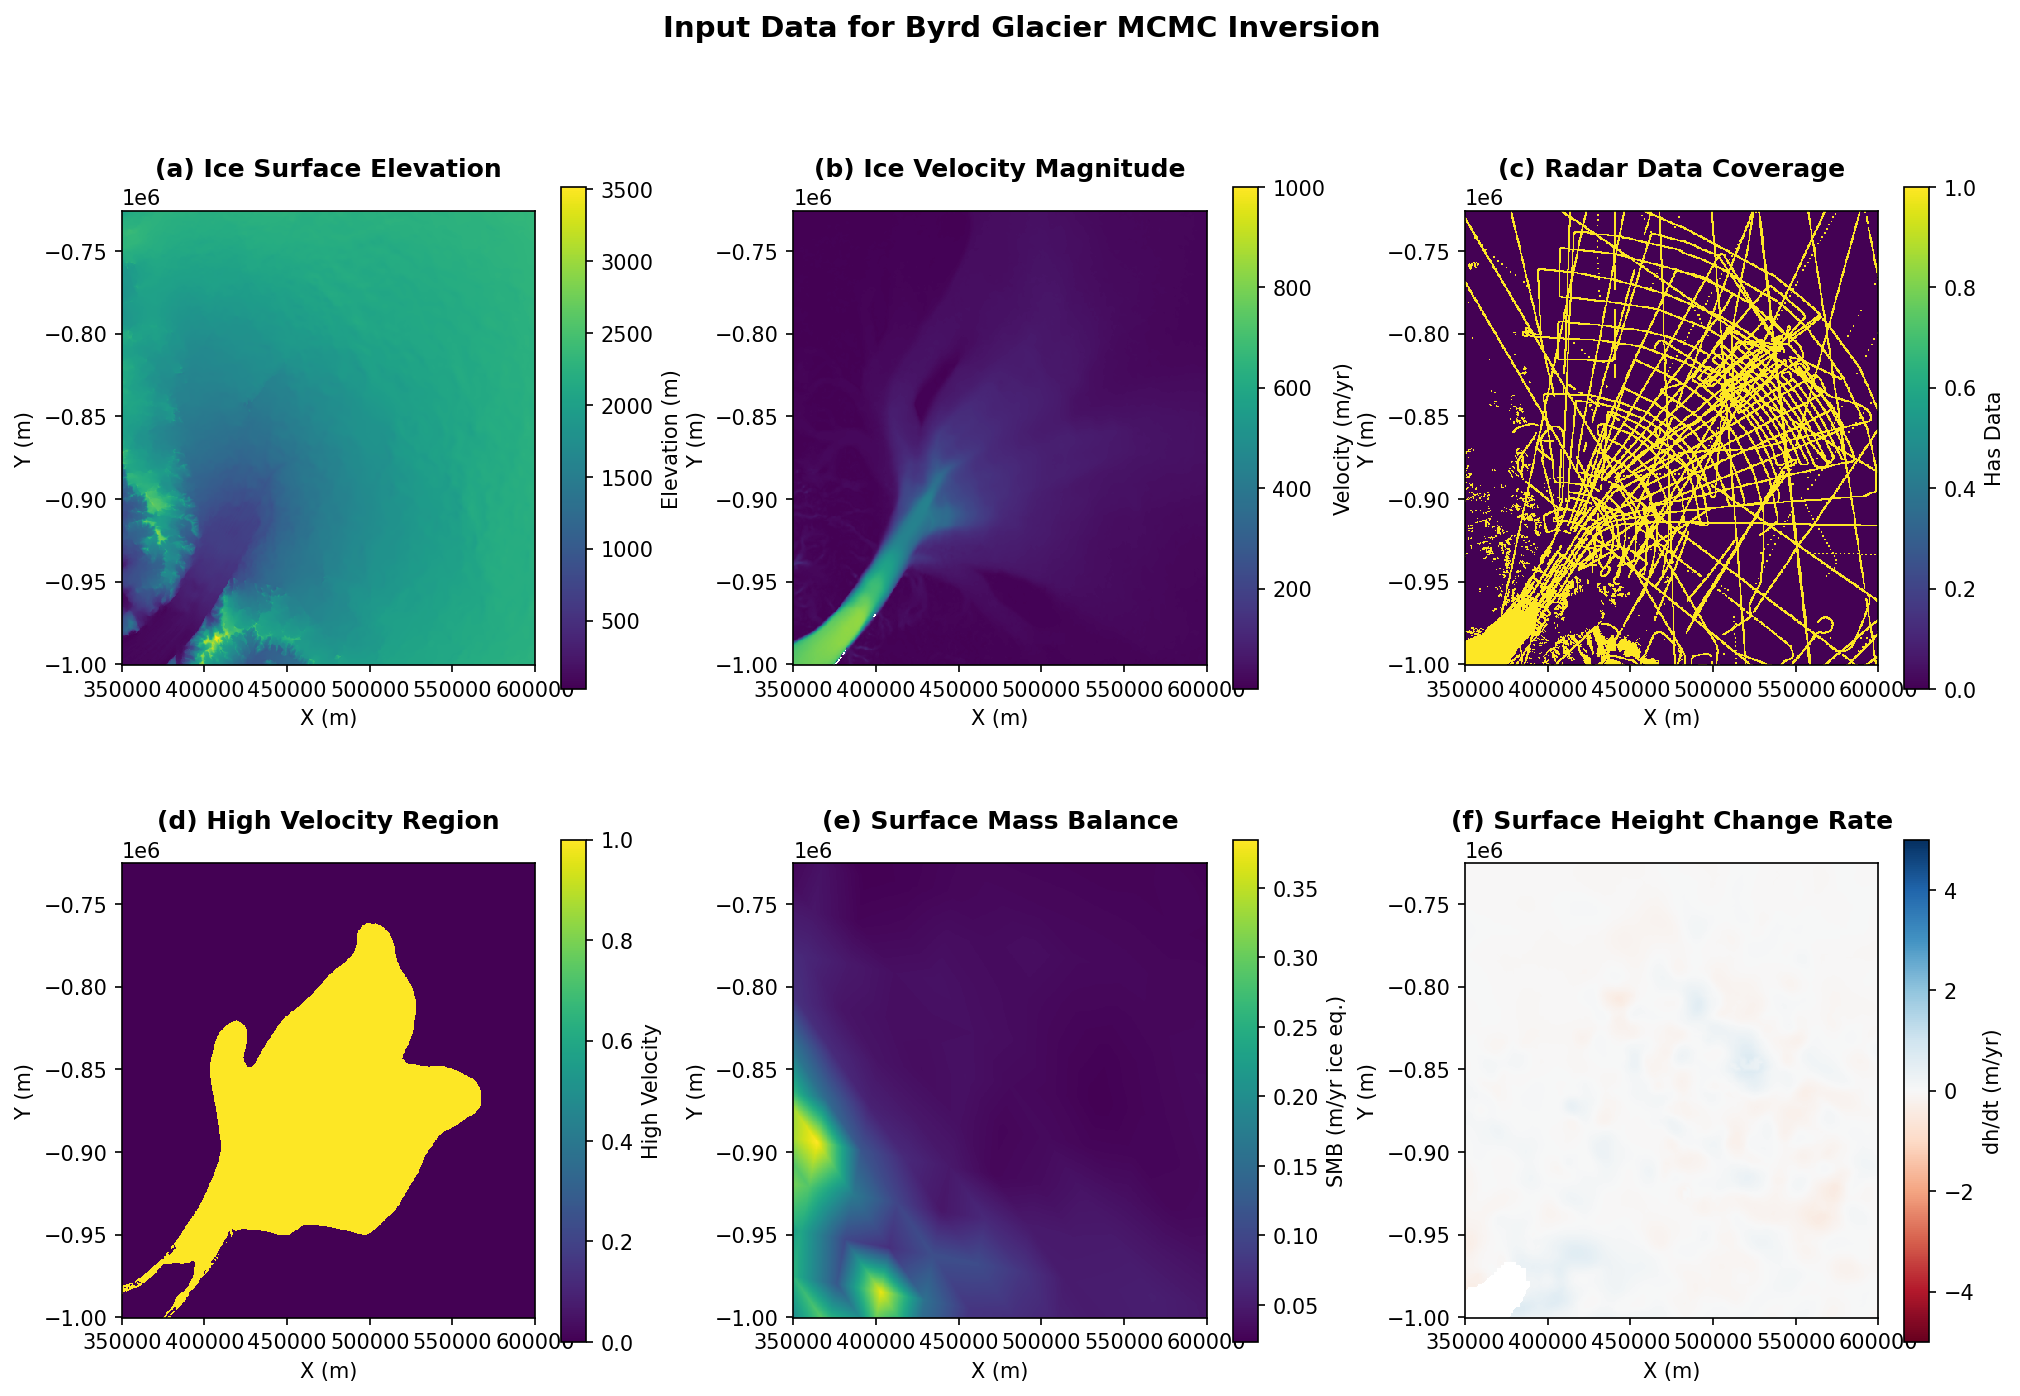

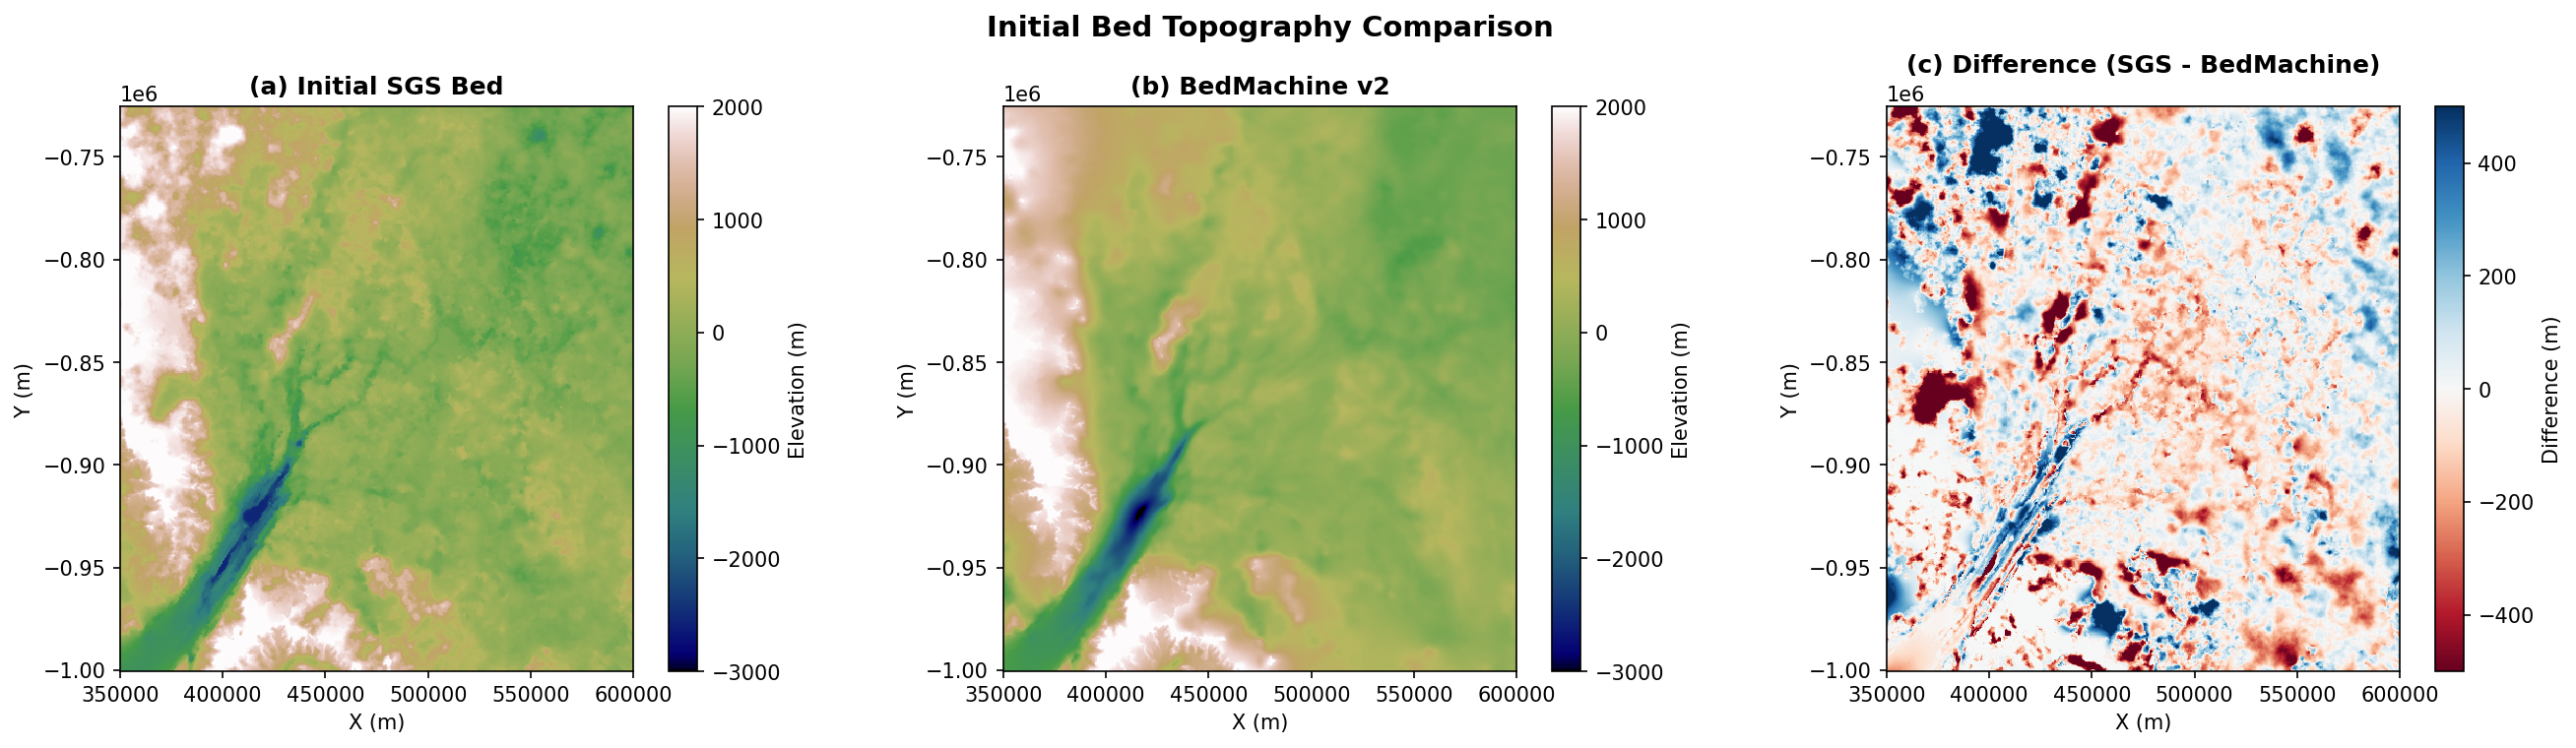

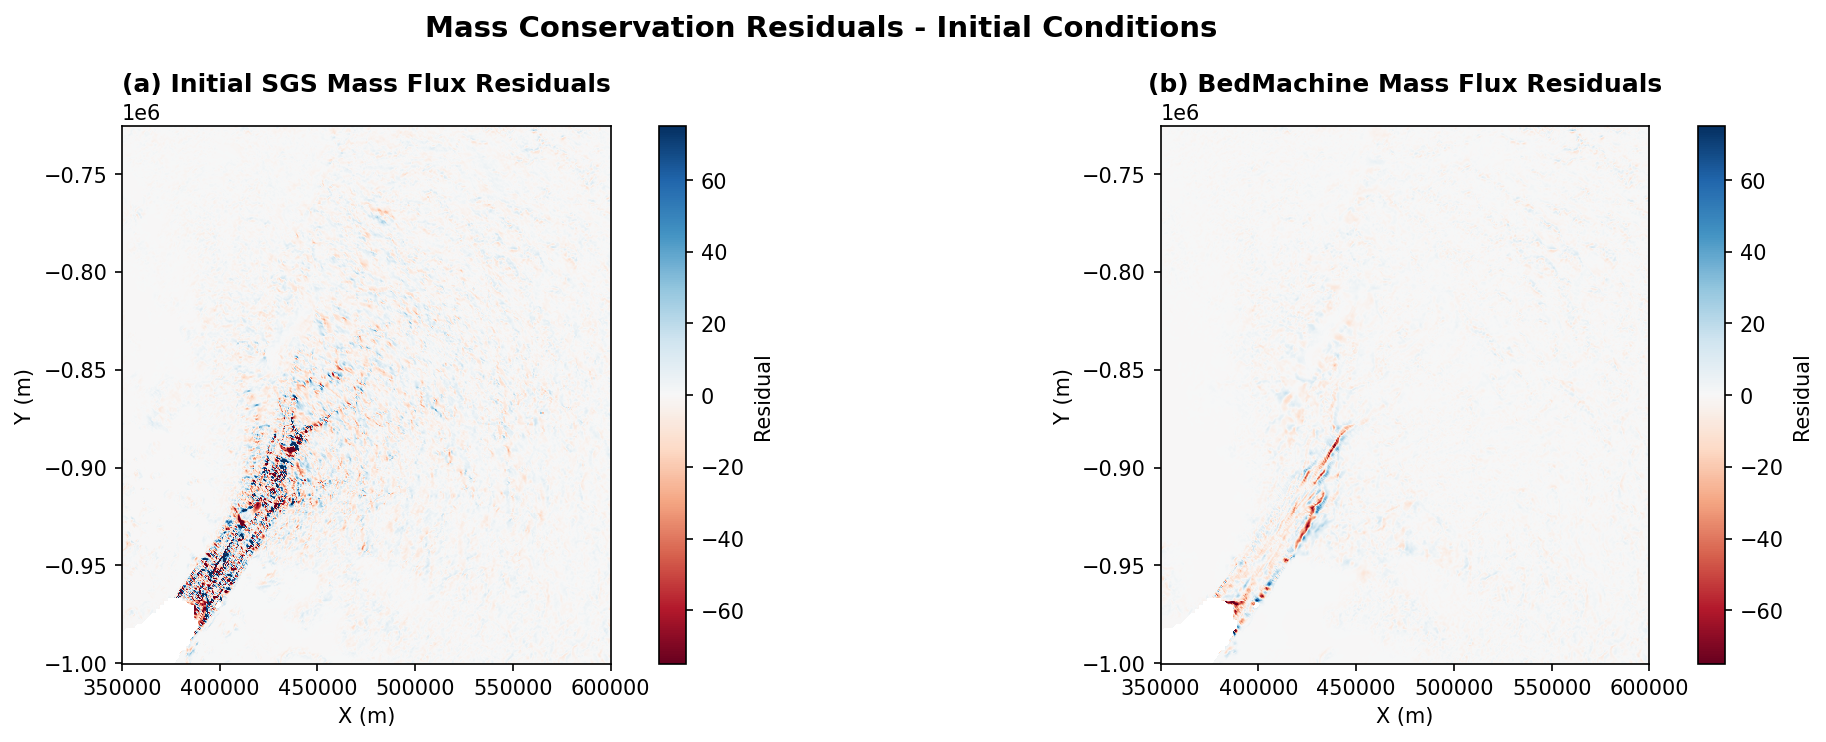

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)
the update blocks is set to be randomly generated for any locations inside the given region


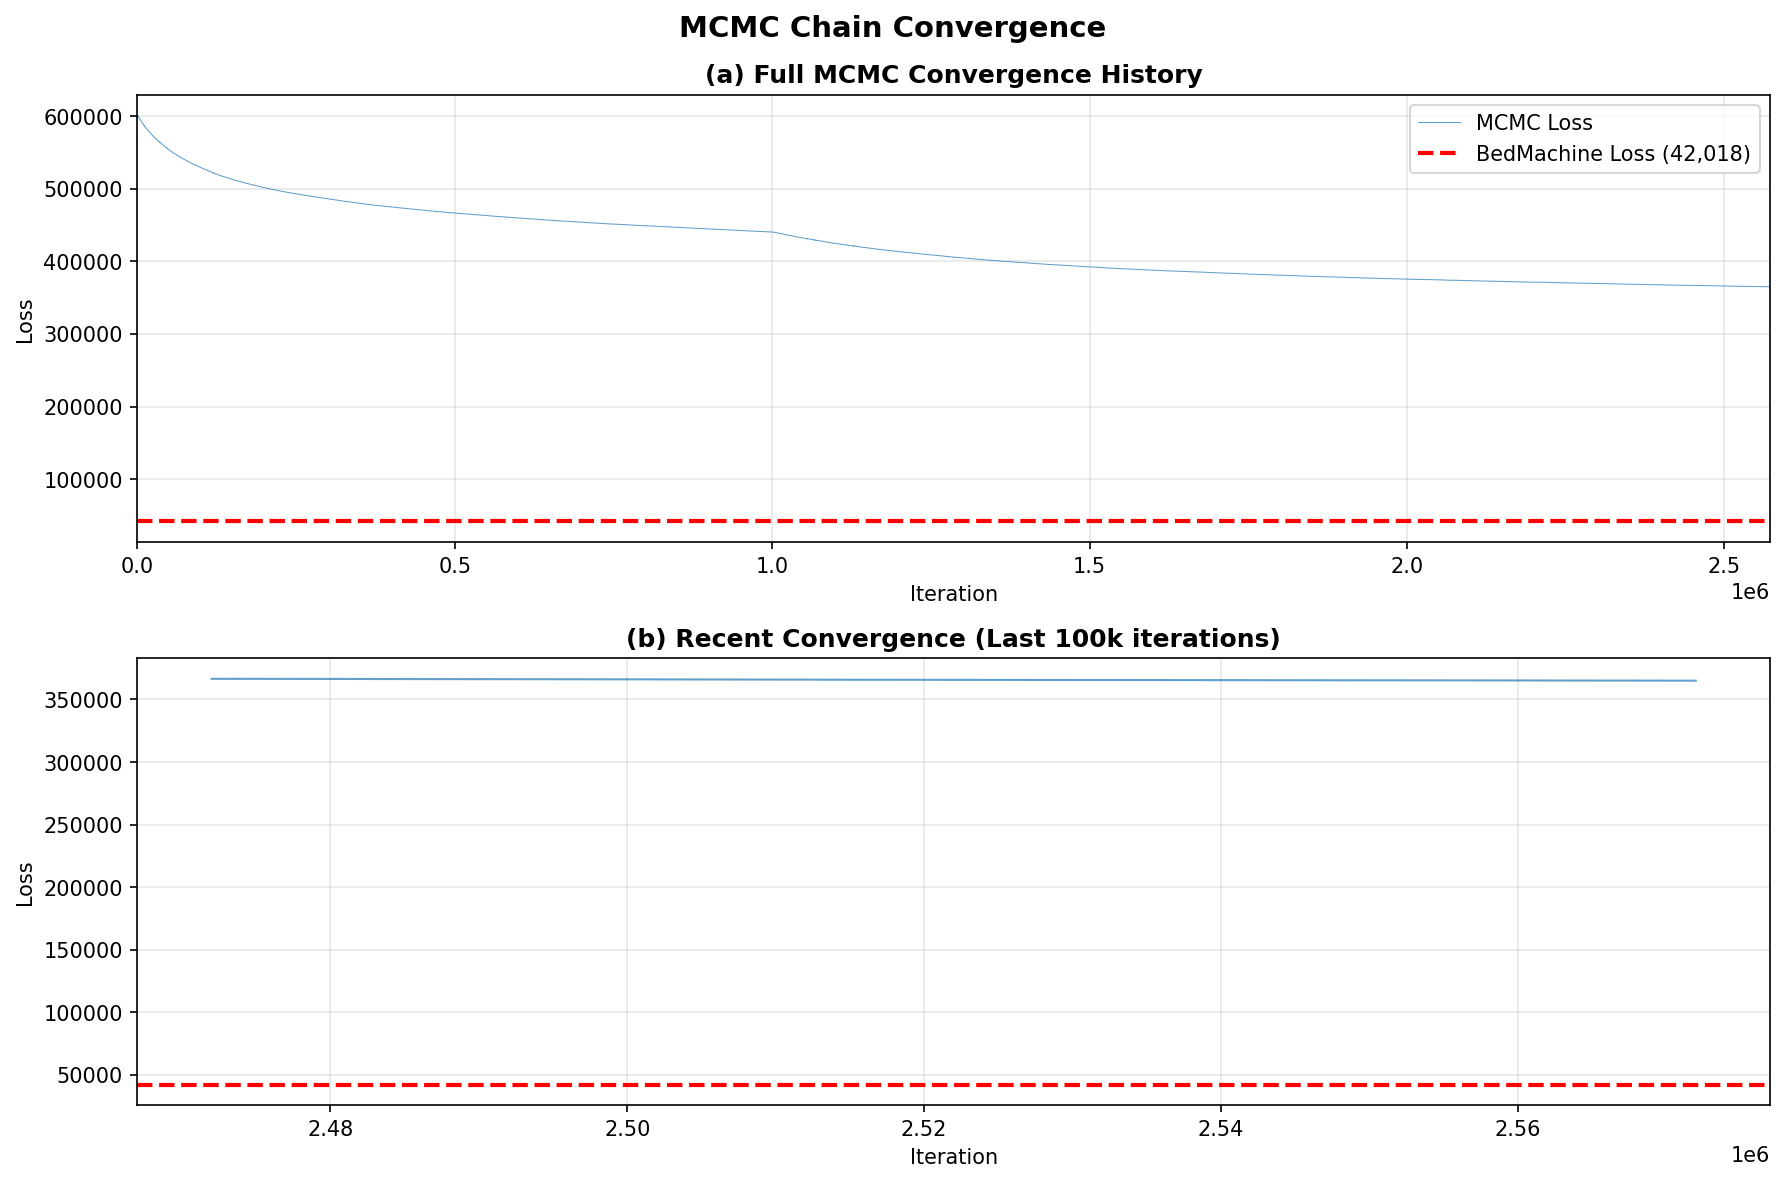

Initial Loss: 601,122
Final Loss: 365,017
Total Improvement: 236,105
BedMachine Loss: 42,018
Ratio to BedMachine: 8.7×


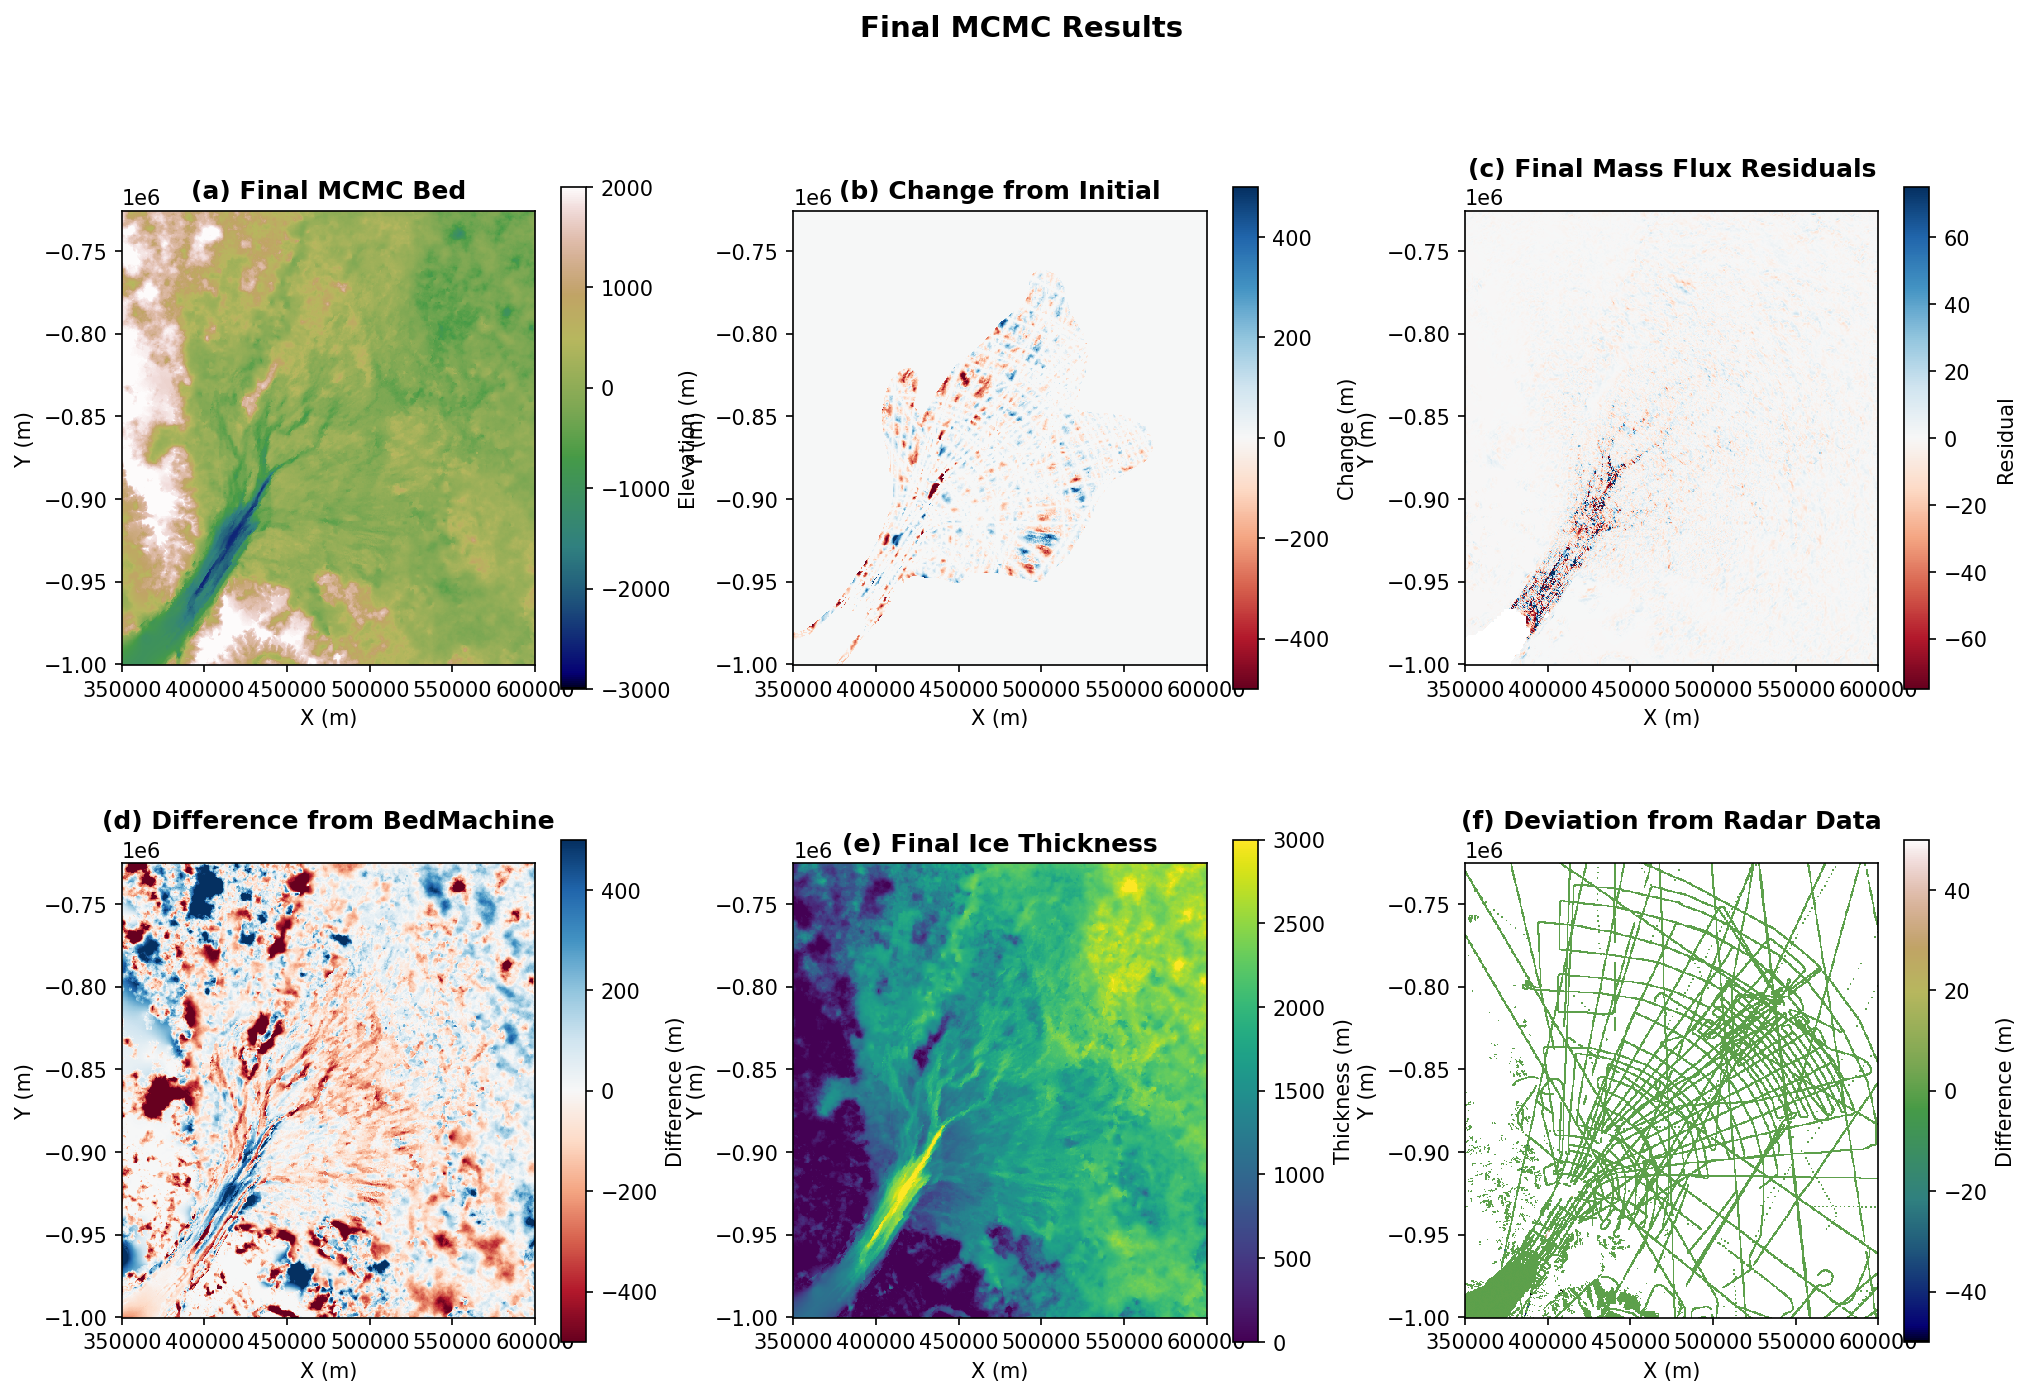

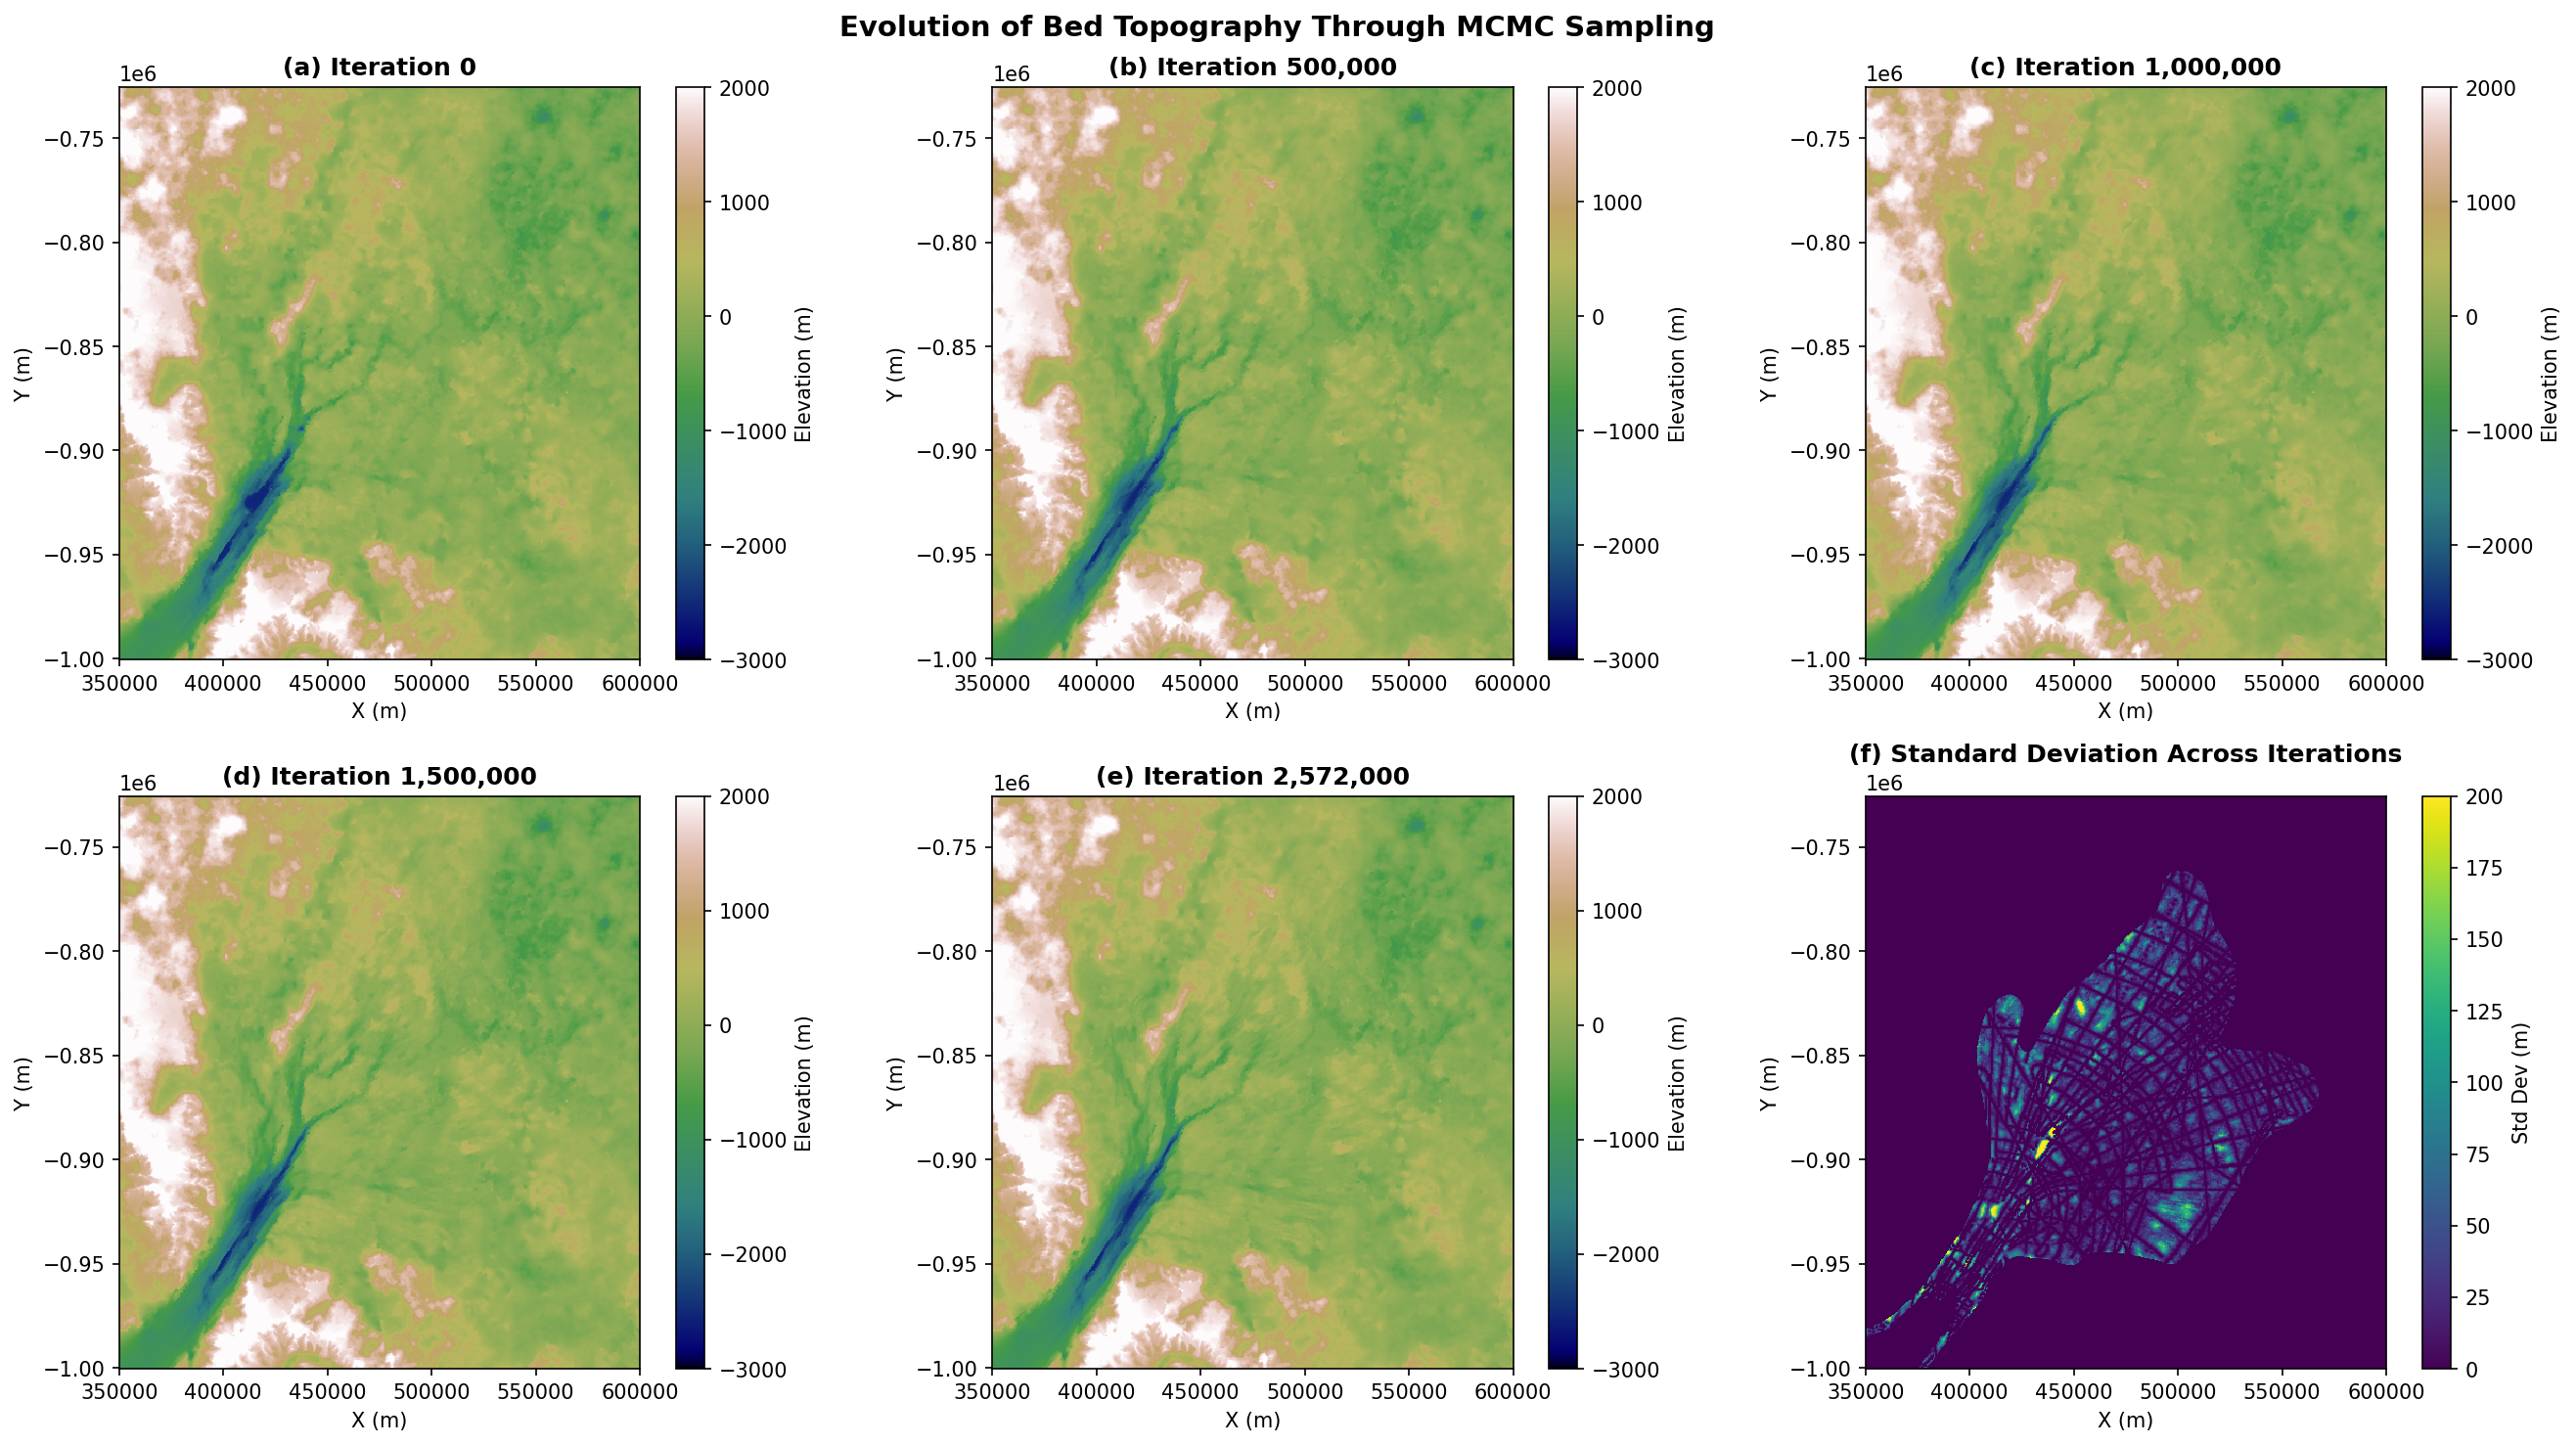


✅ ALL FIGURES GENERATED SUCCESSFULLY!
Saved files:
  - Figure1_InputData.png
  - Figure2_InitialConditions.png
  - Figure3_MassConservation_Initial.png
  - Figure4_Convergence.png
  - Figure5_FinalResults.png
  - Figure6_MCMC_Evolution.png


In [76]:
# ==============================================================================
# Run these cells to generate figures
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography, MCMC
import matplotlib.gridspec as gridspec

# Set up nice plotting defaults
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

resolution = 500

# ==============================================================================
# FIGURE 1: Input Data Overview
# ==============================================================================
fig = plt.figure(figsize=(16, 10))
gs_main = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Surface elevation  *** FIXED: use default colormap (like load_bedmap fig) ***
ax1 = fig.add_subplot(gs_main[0, 0])
im1 = ax1.pcolormesh(xx, yy, bedmap_surf)  # no cmap -> default (viridis)
ax1.set_title('(a) Ice Surface Elevation', fontsize=12, fontweight='bold')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_aspect('equal')
plt.colorbar(im1, ax=ax1, label='Elevation (m)')

# Velocity magnitude
vel_mag = np.sqrt(velx**2 + vely**2)
ax2 = fig.add_subplot(gs_main[0, 1])
im2 = ax2.pcolormesh(xx, yy, vel_mag, cmap='viridis', vmax=1000)
ax2.set_title('(b) Ice Velocity Magnitude', fontsize=12, fontweight='bold')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_aspect('equal')
plt.colorbar(im2, ax=ax2, label='Velocity (m/yr)')

# Conditioning data mask
ax3 = fig.add_subplot(gs_main[0, 2])
im3 = ax3.pcolormesh(xx, yy, data_mask, cmap='viridis')
ax3.set_title('(c) Radar Data Coverage', fontsize=12, fontweight='bold')
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_aspect('equal')
plt.colorbar(im3, ax=ax3, label='Has Data')

# High velocity mask
ax4 = fig.add_subplot(gs_main[1, 0])
im4 = ax4.pcolormesh(xx, yy, highvel_mask, cmap='viridis')
ax4.set_title('(d) High Velocity Region', fontsize=12, fontweight='bold')
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_aspect('equal')
plt.colorbar(im4, ax=ax4, label='High Velocity')

# SMB
ax5 = fig.add_subplot(gs_main[1, 1])
im5 = ax5.pcolormesh(xx, yy, smb, cmap='viridis')
ax5.set_title('(e) Surface Mass Balance', fontsize=12, fontweight='bold')
ax5.set_xlabel('X (m)')
ax5.set_ylabel('Y (m)')
ax5.set_aspect('equal')
plt.colorbar(im5, ax=ax5, label='SMB (m/yr ice eq.)')

# dh/dt
ax6 = fig.add_subplot(gs_main[1, 2])
im6 = ax6.pcolormesh(xx, yy, dhdt, cmap='RdBu', vmin=-5, vmax=5)
ax6.set_title('(f) Surface Height Change Rate', fontsize=12, fontweight='bold')
ax6.set_xlabel('X (m)')
ax6.set_ylabel('Y (m)')
ax6.set_aspect('equal')
plt.colorbar(im6, ax=ax6, label='dh/dt (m/yr)')

plt.suptitle('Input Data for Byrd Glacier MCMC Inversion', 
             fontsize=14, fontweight='bold', y=0.995)
plt.savefig('Figure1_InputData.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# FIGURE 2: Initial Conditions
# ==============================================================================
bed_initial = np.loadtxt('sgsOG_bed.txt')
bedmachine_bed = bedmap_surf - bedmachine_thickness

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].pcolormesh(xx, yy, bed_initial, cmap='gist_earth', vmin=-3000, vmax=2000)
axes[0].set_title('(a) Initial SGS Bed', fontsize=12, fontweight='bold')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Elevation (m)')

im2 = axes[1].pcolormesh(xx, yy, bedmachine_bed, cmap='gist_earth', vmin=-3000, vmax=2000)
axes[1].set_title('(b) BedMachine v2', fontsize=12, fontweight='bold')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Elevation (m)')

diff = bed_initial - bedmachine_bed
im3 = axes[2].pcolormesh(xx, yy, diff, cmap='RdBu', vmin=-500, vmax=500)
axes[2].set_title('(c) Difference (SGS - BedMachine)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].set_aspect('equal')
plt.colorbar(im3, ax=axes[2], label='Difference (m)')

plt.suptitle('Initial Bed Topography Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Figure2_InitialConditions.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# FIGURE 3: Mass Conservation Residuals - Initial
# ==============================================================================
mc_res_initial = Topography.get_mass_conservation_residual(
    bed_initial, bedmap_surf, velx, vely, dhdt, smb, resolution
)
mc_res_bm = Topography.get_mass_conservation_residual(
    bedmachine_bed, bedmap_surf, velx, vely, dhdt, smb, resolution
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].pcolormesh(xx, yy, mc_res_initial, cmap='RdBu', vmin=-75, vmax=75)
axes[0].set_title('(a) Initial SGS Mass Flux Residuals', fontsize=12, fontweight='bold')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Residual')

im2 = axes[1].pcolormesh(xx, yy, mc_res_bm, cmap='RdBu', vmin=-75, vmax=75)
axes[1].set_title('(b) BedMachine Mass Flux Residuals', fontsize=12, fontweight='bold')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Residual')

plt.suptitle('Mass Conservation Residuals - Initial Conditions', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Figure3_MassConservation_Initial.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# FIGURE 4: MCMC Convergence
# ==============================================================================
all_loss = []
max_iter = 2572000

for i in range(0, max_iter, 1000):
    try:
        loss_chunk = np.loadtxt(f'lossOG_{i}to{i+1000}')
        all_loss.append(loss_chunk)
    except FileNotFoundError:
        break

loss_array = np.concatenate(all_loss)
iterations = np.arange(len(loss_array))

largeScaleChain = MCMC.chain_crf(
    xx, yy, bed_initial, bedmap_surf, velx, vely,
    dhdt, smb, cond_bed, data_mask,
    (bedmap_mask == 1), resolution
)

largeScaleChain.set_update_region(True, highvel_mask)
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)
loss_bm = largeScaleChain.loss(mc_res_bm, 0)[0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(iterations, loss_array, linewidth=0.5, alpha=0.7, label='MCMC Loss')
ax1.axhline(loss_bm, color='red', linestyle='--', linewidth=2, label=f'BedMachine Loss ({loss_bm:,.0f})')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('(a) Full MCMC Convergence History', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, len(loss_array)])

zoom_start = max(0, len(loss_array) - 100000)
ax2.plot(iterations[zoom_start:], loss_array[zoom_start:], linewidth=1, alpha=0.7)
ax2.axhline(loss_bm, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('(b) Recent Convergence (Last 100k iterations)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('MCMC Chain Convergence', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Figure4_Convergence.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Initial Loss: {loss_array[0]:,.0f}")
print(f"Final Loss: {loss_array[-1]:,.0f}")
print(f"Total Improvement: {loss_array[0] - loss_array[-1]:,.0f}")
print(f"BedMachine Loss: {loss_bm:,.0f}")
print(f"Ratio to BedMachine: {loss_array[-1]/loss_bm:.1f}×")

# ==============================================================================
# FIGURE 5: Final Results
# ==============================================================================
bed_final = np.loadtxt('bedsOG_at_2572000th_iteration')

mc_res_final = Topography.get_mass_conservation_residual(
    bed_final, bedmap_surf, velx, vely, dhdt, smb, resolution
)

fig = plt.figure(figsize=(16, 10))
gs_main = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs_main[0, 0])
im1 = ax1.pcolormesh(xx, yy, bed_final, cmap='gist_earth', vmin=-3000, vmax=2000)
ax1.set_title('(a) Final MCMC Bed', fontsize=12, fontweight='bold')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_aspect('equal')
plt.colorbar(im1, ax=ax1, label='Elevation (m)')

ax2 = fig.add_subplot(gs_main[0, 1])
change = bed_final - bed_initial
im2 = ax2.pcolormesh(xx, yy, change, cmap='RdBu', vmin=-500, vmax=500)
ax2.set_title('(b) Change from Initial', fontsize=12, fontweight='bold')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_aspect('equal')
plt.colorbar(im2, ax=ax2, label='Change (m)')

ax3 = fig.add_subplot(gs_main[0, 2])
im3 = ax3.pcolormesh(xx, yy, mc_res_final, cmap='RdBu', vmin=-75, vmax=75)
ax3.set_title('(c) Final Mass Flux Residuals', fontsize=12, fontweight='bold')
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_aspect('equal')
plt.colorbar(im3, ax=ax3, label='Residual')

ax4 = fig.add_subplot(gs_main[1, 0])
diff_bm = bed_final - bedmachine_bed
im4 = ax4.pcolormesh(xx, yy, diff_bm, cmap='RdBu', vmin=-500, vmax=500)
ax4.set_title('(d) Difference from BedMachine', fontsize=12, fontweight='bold')
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_aspect('equal')
plt.colorbar(im4, ax=ax4, label='Difference (m)')

ax5 = fig.add_subplot(gs_main[1, 1])
thickness_final = bedmap_surf - bed_final
im5 = ax5.pcolormesh(xx, yy, thickness_final, cmap='viridis', vmin=0, vmax=3000)
ax5.set_title('(e) Final Ice Thickness', fontsize=12, fontweight='bold')
ax5.set_xlabel('X (m)')
ax5.set_ylabel('Y (m)')
ax5.set_aspect('equal')
plt.colorbar(im5, ax=ax5, label='Thickness (m)')

# *** FIXED: create ax6 explicitly and pass the mappable to colorbar ***
ax6 = fig.add_subplot(gs_main[1, 2])
diff_cond = bed_final - cond_bed
im6 = ax6.pcolormesh(xx, yy, diff_cond, cmap='gist_earth', vmin=-50, vmax=50)
ax6.set_title('(f) Deviation from Radar Data', fontsize=12, fontweight='bold')
ax6.set_xlabel('X (m)')
ax6.set_ylabel('Y (m)')
ax6.set_aspect('equal')
plt.colorbar(im6, ax=ax6, label='Difference (m)')

plt.suptitle('Final MCMC Results', fontsize=14, fontweight='bold', y=0.995)
plt.savefig('Figure5_FinalResults.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 6: Evolution of Bed Topography
iterations = [0, 500000, 1000000, 1500000, 2572000]
files = [
    'sgsOG_bed.txt',
    'bedsOG_at_500000th_iteration',
    'bedsOG_at_1000000th_iteration', 
    'bedsOG_at_1500000th_iteration',
    'bedsOG_at_2572000th_iteration'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

realizations = []
for idx, (iter_num, filename) in enumerate(zip(iterations, files)):
    bed = np.loadtxt(filename)
    realizations.append(bed)
    
    im = axes[idx].pcolormesh(xx, yy, bed, cmap='gist_earth', vmin=-3000, vmax=2000)
    axes[idx].set_title(f'({"abcde"[idx]}) Iteration {iter_num:,}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('X (m)')
    axes[idx].set_ylabel('Y (m)')
    axes[idx].set_aspect('equal')
    plt.colorbar(im, ax=axes[idx], label='Elevation (m)')

ensemble_std = np.std(realizations, axis=0)
im = axes[5].pcolormesh(xx, yy, ensemble_std, cmap='viridis', vmin=0, vmax=200)
axes[5].set_title('(f) Standard Deviation Across Iterations', 
                  fontsize=12, fontweight='bold')
axes[5].set_xlabel('X (m)')
axes[5].set_ylabel('Y (m)')
axes[5].set_aspect('equal')
plt.colorbar(im, ax=axes[5], label='Std Dev (m)')

plt.suptitle('Evolution of Bed Topography Through MCMC Sampling', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Figure6_MCMC_Evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ALL FIGURES GENERATED SUCCESSFULLY!")
print("Saved files:")
print("  - Figure1_InputData.png")
print("  - Figure2_InitialConditions.png")
print("  - Figure3_MassConservation_Initial.png")
print("  - Figure4_Convergence.png")
print("  - Figure5_FinalResults.png")
print("  - Figure6_MCMC_Evolution.png")
